<a href="https://colab.research.google.com/github/anubhavsatpathy/EVA/blob/master/Session5/EVA_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Network Regularization and Batch Normalization

This assignment's objectives are to :

- Create a custom loss function to add L2 penalty to the cross-entropy loss
- Add Batch Normalization during training and testing
- Print a set of 25 misclassified images from our validation set

The code below installs Keras and imports keras and tensorflow to the python runtime

In [0]:
!pip install -q keras
import keras
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


###Importing Modules:

We utilize the code snippen below to import modules to our runtime so that we can use the interfaces exposed by these modules to write and adjust our CNN. We describe only a few modules below that we have not covered in previous assignments:

- **ModelCheckpoint** : This is among the many callbacks provided by Keras that we can use while training our model. We will use this to store the best model weights so that we do not loose out on them by updations performed during subsequent epochs ([Documentation](https://keras.io/callbacks/))

- **ImageDataGenerator** : This module helps us perform image augmentation which is a very strong regularization measure. We can use this to apply transformations like rotation, translation, random crop etc. on out training dataset before passing them on to the network ([Documentation](https://keras.io/preprocessing/image/))

- **Dropout** : This a keras layer that implements dropouts. Dropouts are another regurarization mechanism that drop certain pixel values while training the model so that our model does not overfit to the training images ([Documentation](https://keras.io/layers/core/))

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from keras.datasets import mnist
from keras.utils import plot_model

from matplotlib import pyplot as plt
%matplotlib inline

###Hyper-Parameters

Each machine learning model will have certain hyper-parameters like batch-size, input shape etc. that are essentially training invariants and are actually agnostic to the model at hand.

To make it easier to iterate with changing these parameters - we usually define them at one place and keep referring to them. This is why we define the dictionary PARAMS in the code below

In [0]:
PARAMS = {
    'INPUT_SHAPE' : (28,28,1),
    'EPOCHS' : 10
}

### Loading and Pre-Processing the Data:

We have been doing these steps for the last two assignments and are now now quite familiar with what these steps do and why are they necessary. Hence - It becomes worthless to inflate our notebook by writing shapes and random images to the console

This is why we wrap all of the data-loading and pre-processing code into a function called load_data() and call this in main() to load the data into our runtime variables *X_train, Y_train, X_test and Y_test*

In [0]:
def load_data():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
  X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_train /= 255
  X_test /= 255
  Y_train = np_utils.to_categorical(y_train, 10)
  Y_test = np_utils.to_categorical(y_test, 10)
  return (X_train, Y_train),(X_test, Y_test)

(X_train, Y_train),(X_test, Y_test) = load_data()

11493376/11490434 [==============================] - 0s 0us/step


###Image Augmentation:

This time we create 2 augmentation pipelines - we call them out train input pipeline and our test input pipeline. The *train pipeline* takes X_train and Y_train as input, normalizes them, randomly shifts, zooms and rotates them and outputs a python generator that yeilds batches

The *test pipeline* does the same except if only normalizes the images. This is required since a network trained on normalized images will not perform that well when given non-normalized images.



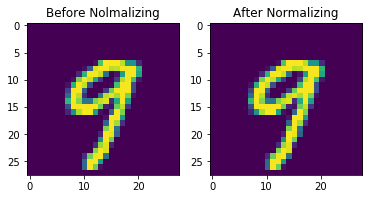

In [0]:

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(X_train)
test_datagen.fit(X_test)

fig, ax = plt.subplots(1,2)
img = X_train[45]
ax[0].imshow(img.reshape(28,28))
ax[0].set_title("Before Nolmalizing")
train_datagen.standardize(img.reshape(1,28,28,1))
ax[1].imshow(img.reshape(28,28))
ax[1].set_title("After Normalizing")
plt.show()

train_data_iter = train_datagen.flow(X_train,Y_train, batch_size = 64)
test_data_iter =  test_datagen.flow(X_test,Y_test, batch_size = 10000)

###Defining our Loss
This is the tricky part of the assignment. What we need to do is to create a loss function that does this:

Loss = Cross_Entropy + L2 Loss

L2 Loss = *f(Weights)*

We break down our function in the following steps:

- **Keras Loss** : A keras loss is a funtion that takes two arguments *(y_true, y_pred)* and returns a scalar - We define this as the function loss() that we return from within custom_loss. This has been done to make lambda configurable
- **Regularization Loss** : Inside our loss function we iterate through the layers of our model and if the layer is a convolution layer we sum the squares of it's weights in a variable. Finally we multiply this variable with our lambda and add out categorical_cross_entropy loss

In [0]:
def custom_loss(lambd, model, batch_size):
  
  def loss(y_true, y_pred):
    reg_loss = 0.0;
    for layer in model.layers:
      if layer.get_config()['name'].startswith('conv'):
        reg_loss += K.sum(K.square(layer.weights[0]))
    l2_loss = (lambd/(2*batch_size))*reg_loss
    return K.categorical_crossentropy(y_true,y_pred) + l2_loss
  return loss
    
  

###Validating our Loss:

In order to validate our loss function - we define a custom callback that saves the sum of squares of the weights after every training batch. The idea is that on plotting these values - The ones while using the custom loss will be much lower than the ones while using normal cross entropy

In [0]:
class WeightHistory(keras.callbacks.Callback):
  def __init__(self, model):
    self._model = model
    self._mean_weights = []
  
  def on_batch_end(self, batch, logs):
    m_w = 0.0
    for layer in self._model.layers:
      if layer.get_config()['name'].startswith('conv'):
        m_w += np.sum(np.square(layer.get_weights()[0]))
    self._mean_weights.append(m_w)
      
  def get_mean_weights(self):
    return self._mean_weights

###Defining our training method

We encapsulate our training method within two functions - one that uses the custom loss while compiling the model and another that uses the the categorical cross entropy loss

These functions do the following:

- They **return the history** of the training
- They **save the best** model weights during training

In [0]:
def train_with_l2_loss(num_epochs, steps, verbosity = 0, calculate_means = True, lambd = 0.1, fname = 'best_l2_loss.hdf5'):
  model = get_model()
  model.compile(loss= custom_loss(lambd, model, 64),
             optimizer='adam',
             metrics=['accuracy'])

  weight_means = WeightHistory(model)

  CKPT = ModelCheckpoint(filepath = fname, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)

  cbacks = [CKPT]
  
  if calculate_means:
    cbacks.append(weight_means)
  
  H = model.fit_generator(train_data_iter, steps_per_epoch = steps, epochs = num_epochs, callbacks = cbacks, validation_data = test_data_iter.next(), verbose = verbosity)
  
  return (H, weight_means)

def train_with_categorical_cross_entropy(num_epochs, steps, verbosity = 0, calculate_means = True, fname = 'best_ce_loss.hdf5'):
  model = get_model()
  model.compile(loss= 'categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

  weight_means = WeightHistory(model)

  CKPT = ModelCheckpoint(filepath = fname, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)

  cbacks = [CKPT]
  
  if calculate_means:
    cbacks.append(weight_means)
  
  H = model.fit_generator(train_data_iter, steps_per_epoch = steps, epochs = num_epochs, callbacks = cbacks, validation_data = test_data_iter.next(), verbose = verbosity)
  
  return (H, weight_means)

###Defining our model:

The code below does the following:

- Encapsulates the model within a getter function so our train methods have access to brand new models - The only difference in our models is that we add Batch Normalization before ReLU for each convolution layer

- Train two new models for 4 epochs of a 100 steps each - one with the custom loss function and another with the categorical cross entropy loss

- Plot the sum of weights returned by these two methods

What we observe is that while using our custom loss - Our weights saturate at a much lower level than while using our cross entropy loss - This validates our loss function for us

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), input_shape=(28, 28, 1..., use_bias=False)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), use_bias=False)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to t


Epoch 00001: val_acc improved from -inf to 0.57140, saving model to best_l2_loss.hdf5

Epoch 00002: val_acc improved from 0.57140 to 0.77470, saving model to best_l2_loss.hdf5

Epoch 00003: val_acc improved from 0.77470 to 0.90680, saving model to best_l2_loss.hdf5

Epoch 00004: val_acc improved from 0.90680 to 0.94880, saving model to best_l2_loss.hdf5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), input_shape=(28, 28, 1..., use_bias=False)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), use_bias=False)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to t

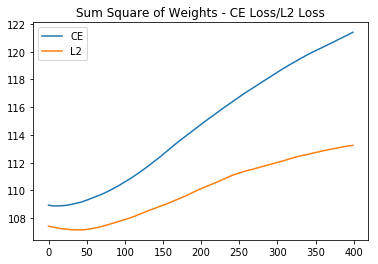

In [0]:
def get_model():
  model = Sequential()

  #out_shape : [b_s, 26, 26, 8], GRF_of_activations : [3,3]
  model.add(Convolution2D(8, 3, 3, input_shape=PARAMS['INPUT_SHAPE'], bias = False))#26
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.05))

  #out_shape : [b_s, 24, 24, 16], GRF_of_activations : [5,5]
  model.add(Convolution2D(16, 3, 3, bias = False))#24
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.05))

  # out_shape : [b_s, 22, 22, 24], GRF_of_activations : [7,7]
  model.add(Convolution2D(24,3,3, bias = False))#22
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.05))

  # out_shape : [b_s, 11, 11, 24], GRF_of_activations : [8,8]
  model.add(MaxPooling2D(2,2))#11
  # out_shape : [b_s, 11, 11, 8], GRF_of_activations : [8,8]
  model.add(Convolution2D(8, 1, 1, bias = False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.05))

  # out_shape : [b_s, 9, 9, 8], GRF_of_activations : [12,12]
  model.add(Convolution2D(8, 3, 3, bias = False))#9
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.05))

  # out_shape : [b_s, 7, 7, 12], GRF_of_activations : [16,16]
  model.add(Convolution2D(12, 3, 3, bias = False))#7
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.05))

  # out_shape : [b_s, 5, 5, 24], GRF_of_activations : [20,20]
  model.add(Convolution2D(24, 3, 3, bias = False))#5
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.05))

  # out_shape : [b_s, 3, 3, 10], GRF_of_activations : [24,24]
  model.add(Convolution2D(16, 3, 3, bias = False))#3
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.05))

  # out_shape : [b_s, 1, 1, 10], GRF_of_activations : [28,28]
  model.add(Convolution2D(10, 3, 3, bias = False))#1

  model.add(Flatten())
  model.add(Activation('softmax'))  
  
  return model

H_L2_Loss, WMeans_L2_Loss = train_with_l2_loss(4, 100, 0)

H_CE_Loss, WMeans_CE_Loss = train_with_categorical_cross_entropy(4, 100, 0)

fig = plt.figure(1)
plt.plot(WMeans_CE_Loss.get_mean_weights())
plt.title("Sum Square of Weights - CE Loss/L2 Loss")
plt.plot(WMeans_L2_Loss.get_mean_weights())
plt.legend(['CE','L2'], loc = 'upper left')


plt.show()


###Training our model

The code below trains the model for 40 epochs of 1000 batches each with a batch size of 64.

All this while it saves the best model to a file names *best_acc_model.hdf5*

As can be seen the best accuracy reached in 99.46%

In [0]:
H, W = train_with_l2_loss(num_epochs = 40, steps = 1000, verbosity = 1, calculate_means = False, lambd = 0.01, fname = 'best_acc_model.hdf5')

print("Best Validation Accuracy : {}".format(np.max(H.history['val_acc'])))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), input_shape=(28, 28, 1..., use_bias=False)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), use_bias=False)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to t

Epoch 1/40
1000/1000 [==============================] - 181s 181ms/step - loss: 0.5879 - acc: 0.8148 - val_loss: 0.0935 - val_acc: 0.9726

Epoch 00001: val_acc improved from -inf to 0.97260, saving model to best_acc_model.hdf5
Epoch 2/40
1000/1000 [==============================] - 174s 174ms/step - loss: 0.1768 - acc: 0.9493 - val_loss: 0.0662 - val_acc: 0.9827

Epoch 00002: val_acc improved from 0.97260 to 0.98270, saving model to best_acc_model.hdf5
Epoch 3/40
1000/1000 [==============================] - 176s 176ms/step - loss: 0.1384 - acc: 0.9614 - val_loss: 0.0610 - val_acc: 0.9848

Epoch 00003: val_acc improved from 0.98270 to 0.98480, saving model to best_acc_model.hdf5
Epoch 4/40
1000/1000 [==============================] - 178s 178ms/step - loss: 0.1203 - acc: 0.9673 - val_loss: 0.0510 - val_acc: 0.9886

Epoch 00004: val_acc improved from 0.98480 to 0.98860, saving model to best_acc_model.hdf5
Epoch 5/40
1000/1000 [==============================] - 175s 175ms/step - loss: 0.1

###Misclassified images:

The code below does the following:

- Load the best saved model back into the variable model
- Load the test data into the variable *X_val* and *Y_val*
- Get the predictions of this model into *Y_pred*
- Iterate through all validation examples and store the misclassified IDs into an array
- Plot the images of the first 25 elements of this array

As can be seen - these images are really outliers in the sense that it's hard for even a human to recognize these numbers and hence we can be satisfied with the robustness of our model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), input_shape=(28, 28, 1..., use_bias=False)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), use_bias=False)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to t

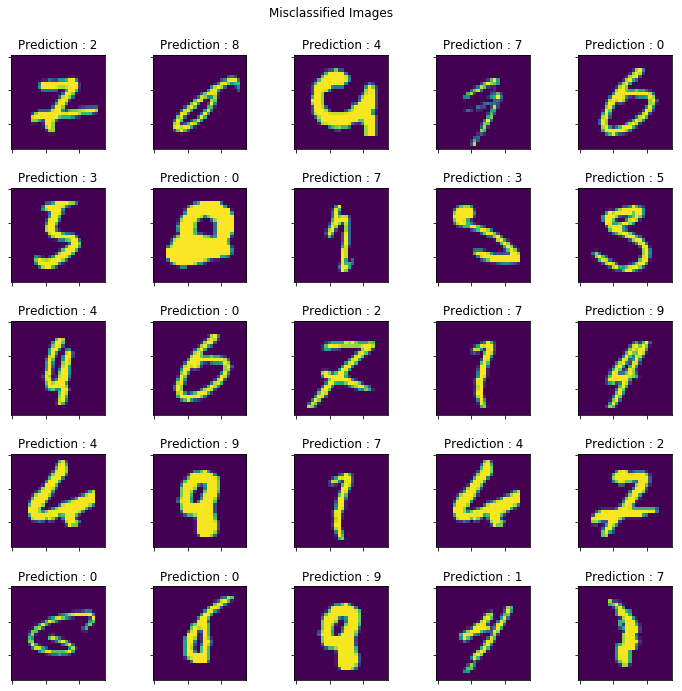

In [0]:
model = get_model()
model.load_weights('./best_acc_model.hdf5')
model.compile(loss= 'categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

X_val,Y_val = test_data_iter.next()

Y_pred = model.predict(X_val)

misclassified_idx = []

for i in range(len(Y_val)):
  if np.argmax(Y_val[i])!= np.argmax(Y_pred[i]):
    misclassified_idx.append(i)

plt_idx = np.random.choice(misclassified_idx, 25)
fig, ax = plt.subplots(5,5,figsize = (10,10))
fig.tight_layout()
fig.suptitle('Misclassified Images')
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)
k = 0
for i in range(5):
  for j in range(5):
    img = X_val[plt_idx[k]].reshape(28,28)
    pred = np.argmax(Y_pred[plt_idx[k]])
    ax[i,j].set_xticklabels([])
    ax[i,j].set_yticklabels([])
    ax[i,j].imshow(img)
    ax[i,j].set_title("Prediction : {}".format(pred))
    k += 1

#print(ax.shape)